## 偏差和方差

In [48]:
import numpy as np
import scipy.io as sio
import scipy.optimize as opt
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [49]:
def load_data():
    d = sio.loadmat('ex5data1.mat')
    # print(d)
    return map(np.ravel, [d['X'], d['y'], d['Xval'], d['yval'], d['Xtest'], d['ytest']])

In [50]:
X, y, Xval, yval, Xtest, ytest = load_data()

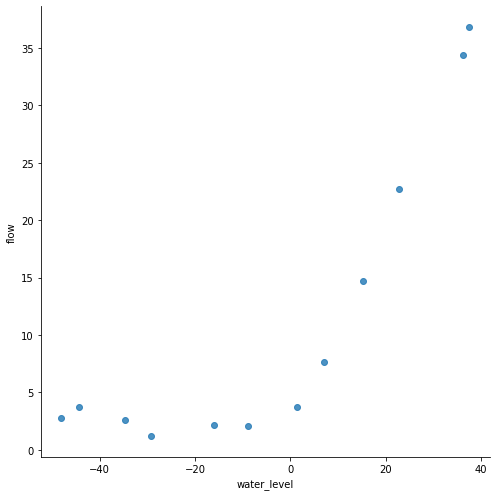

In [51]:
df = pd.DataFrame({'water_level':X, 'flow':y})

sns.lmplot(x='water_level', y='flow', data=df, fit_reg=False, height=7)
plt.show()

In [52]:
X, Xval, Xtest = [np.insert(x.reshape(x.shape[0], 1), 0, np.ones(x.shape[0]), axis=1) for x in (X, Xval, Xtest)]

In [53]:
# print(X,Xval,Xtest)

X.shape

(12, 2)

## 代价函数

In [54]:
def cost(theta, X, y):
    # X: R(m*n), m records, n features
    # y: R(m)
    # theta: R(n), linear regression parameters
    
    m = X.shape[0]
    
    inner = X @ theta - y # R(m*1)
    
    square_sum = inner.T @ inner
    cost = square_sum / (2 * m)
    
    return cost

In [55]:
theta = np.ones(X.shape[1])
cost(theta, X, y)

303.9515255535976

## 梯度

In [56]:
def gradient(theta, X, y):
    m = X.shape[0]
    
    inner = X.T @ (X @ theta - y) # (m,n).T @ (m,1) -> (n,1)
    
    return inner / m

In [57]:
gradient(theta, X, y)

array([-15.30301567, 598.16741084])

## 正则化梯度

In [58]:
def regularized_gradient(theta, X, y, l=1):
    m = X.shape[0]
    
    regularized_term = theta.copy() # same shape as theta
    regularized_term[0] = 0 # don't regularize intercept theta
    
    regularized_term = (l / m) * regularized_term
    
    return gradient(theta, X, y) + regularized_term

In [59]:
regularized_gradient(theta, X, y)

array([-15.30301567, 598.25074417])

## 拟合数据

> 正则化项 \lambda = 0

In [60]:
def linear_regression_np(X, y ,l=1):
    # init theta
    theta = np.ones(X.shape[1])
    
    # train it
    res = opt.minimize(fun=regularized_cost,
                       x0=theta,
                       args=(X, y, l),
                       method='TNC',
                       jac=regularized_gradient,
                       options={'disp': True})
    return res

In [61]:
def regularized_cost(theta, X, y, l=1):
    m = X.shape[0]
    
    regularized_term = (l / (2 * m)) * np.power(theta[1:], 2).sum()
    
    return cost(theta, X, y) + regularized_term

In [62]:
theta = np.ones(X.shape[0])

final_theta = linear_regression_np(X, y, l=0).get('x')

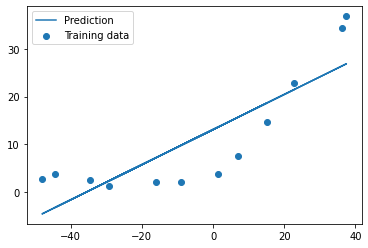

In [63]:
b = final_theta[0] # intercept
m = final_theta[1] # slope

plt.scatter(X[:, 1], y, label="Training data")
plt.plot(X[:, 1], X[:, 1]*m + b, label="Prediction")
plt.legend(loc=2)
plt.show()

In [64]:
training_cost, cv_cost = [], []

- 使用训练集的子集来拟合模型
- 在计算训练代价和交叉验证代价时，没有用正则化
- 记住使用相同的训练集子集来计算训练代价

In [65]:
m = X.shape[0]
for i in range(1, m+1):
    # print('i={}'.format(i))
    res = linear_regression_np(X[:i, :], y[:i], l=0)
    
    tc = regularized_cost(res.x, X[:i, :], y[:i], l=0)
    cv = regularized_cost(res.x, Xval, yval, l=0)
    # print('tc={}, cv={}'.format(tc, cv))
    
    training_cost.append(tc)
    cv_cost.append(cv)

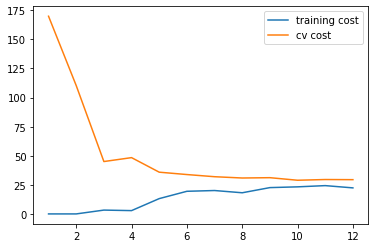

In [66]:
plt.plot(np.arange(1, m+1), training_cost, label='training cost')
plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
plt.legend(loc=1)
plt.show()

这个模型拟合不太好，**欠拟合了**

## 创建多项式特征

In [67]:
def prepare_poly_data(*args, power):
    # args: keep feeding in X, Xval, or Xtest will return in the same order
    def prepare(x):
        # expand feature
        df = poly_features(x, power=power)
        
        # normalization
        ndarr = normalize_feature(df).values
        
        # add intercept term
        return np.insert(ndarr, 0, np.ones(ndarr.shape[0]), axis=1)
    
    return [prepare(x) for x in args]

In [104]:
def poly_features(x, power, as_ndrray=False):
    data = {'f{}'.format(i): np.power(x, i) for i in range(1, power + 1)}
    df = pd.DataFrame(data)
    
    return df.as_matrix() if as_ndrray else df

In [105]:
X, y, Xval, yval, Xtest, ytest = load_data()

In [106]:
poly_feature(X, power=3)

,f1,f2,f3
0,-15.936758,253.980260,-4047.621971
1,-29.152979,849.896197,-24777.006175
2,36.189549,1309.683430,47396.852168
3,37.492187,1405.664111,52701.422173
4,-48.058829,2309.651088,-110999.127750
5,-8.941458,79.949670,-714.866612
6,15.307793,234.328523,3587.052500
7,-34.706266,1204.524887,-41804.560890
8,1.389154,1.929750,2.680720
9,-44.383760,1969.918139,-87432.373590


## 准备多项式回归数据

- 扩展特征到8阶，或者你需要的阶数
- 使用归一化来合并!x(n)
- don't forget intercept term

In [107]:
def normalize_feature(df):
    # Applies function along input axis(default 0) of DataFrame
    return df.apply(lambda column: (column - column.mean()) / column.std())

In [108]:
X_poly, Xval_poly, Xtest_poly = prepare_poly_data(X, Xval, Xtest, power=8)
X_poly[:3, :]

array([[ 1.00000000e+00, -3.62140776e-01, -7.55086688e-01,
         1.82225876e-01, -7.06189908e-01,  3.06617917e-01,
        -5.90877673e-01,  3.44515797e-01, -5.08481165e-01],
       [ 1.00000000e+00, -8.03204845e-01,  1.25825266e-03,
        -2.47936991e-01, -3.27023420e-01,  9.33963187e-02,
        -4.35817606e-01,  2.55416116e-01, -4.48912493e-01],
       [ 1.00000000e+00,  1.37746700e+00,  5.84826715e-01,
         1.24976856e+00,  2.45311974e-01,  9.78359696e-01,
        -1.21556976e-02,  7.56568484e-01, -1.70352114e-01]])

## 画出学习曲线

> 首先，我们没有使用正则化，所以lambda=0

In [68]:
def plot_learning_curve(X, y, Xval, yval, l=0):
    training_cost, cv_cost = [], []
    m = X.shape[0]
    
    for i in range(1, m+1):
        # regularization applies here for fitting parameters
        res = linear_regression_np(X[:i, :], y[:i], l=l)
        
        # remember, when you compute the cost here, you are computing
        # non-regukarized cost, Regularization is used to fit paramerters only
        tc = cost(res.x, X[:i, :], y[:i])
        cv = cost(res.x, Xval, yval)
        
        training_cost.append(tc)
        cv_cost.append(cv)
        
    plt.plot(np.arange(1, m+1), training_cost, label='training cost')
    plt.plot(np.arange(1, m+1), cv_cost, label='cv cost')
    plt.legend(loc=1)

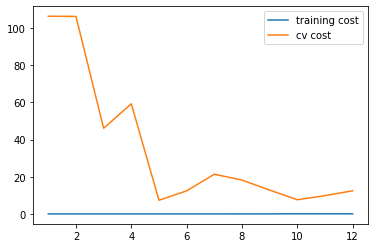

In [110]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=0)
plt.show()

训练的代价太低了，不真实，这是**过拟合了**

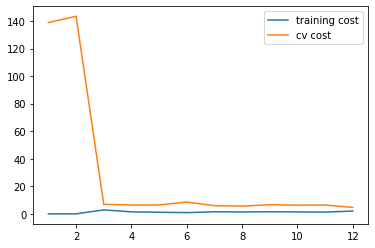

In [111]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=1)
plt.show()

训练代价增加了些，不再是0了。也就是我们说的减轻**过拟合**

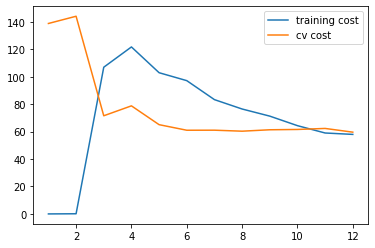

In [112]:
plot_learning_curve(X_poly, y, Xval_poly, yval, l=100)
plt.show()

太多正则化了，变成**欠拟合**状态

## 找到最佳的lambda

In [113]:
l_candidate = [0, 0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]
training_cost, cv_cost = [], []

In [114]:
for l in l_candidate:
    res = linear_regression_np(X_poly, y, l)
    
    tc = cost(res.x, X_poly, y)
    cv = cost(res.x, Xval_poly, yval)
    
    training_cost.append(tc)
    cv_cost.append(cv)

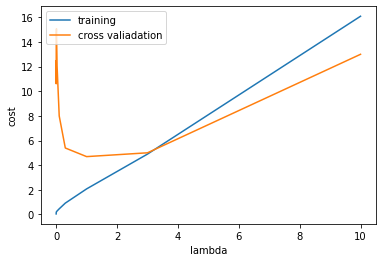

In [115]:
plt.plot(l_candidate, training_cost, label='training')
plt.plot(l_candidate, cv_cost, label='cross valiadation')
plt.legend(loc=2)

plt.xlabel('lambda')
plt.ylabel('cost')
plt.show()

In [116]:
# best cv I got from all those candidates
l_candidate[np.argmin(cv_cost)]

1

In [117]:
# use the data to compute the cost
for l in l_candidate:
    theta = linear_regression_np(X_poly, y, l).x
    print('test cost(l={}) = {}'.format(l, cost(theta, Xtest_poly, ytest)))

test cost(l=0) = 10.055426362410126
test cost(l=0.001) = 11.001927632262907
test cost(l=0.003) = 11.264746551677469
test cost(l=0.01) = 10.880780731411715
test cost(l=0.03) = 10.022100517865269
test cost(l=0.1) = 8.63190793331871
test cost(l=0.3) = 7.3366077892272585
test cost(l=1) = 7.466283751156784
test cost(l=3) = 11.643941860536106
test cost(l=10) = 27.715080254176254


调参后， \lambda = 0.3是最优选择， 这个时候测试代价最小